In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
import datetime  
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller  
from sklearn.preprocessing import MinMaxScaler  
from tensorflow import keras  
from keras import callbacks  
from tensorflow.keras import Sequential  
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional  
from tensorflow.keras.optimizers import SGD  
import math  
from sklearn.metrics import mean_squared_error  
  
import warnings  
warnings.filterwarnings("ignore")  

C:\Users\rohit\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dataset = pd.read_csv("train_aWnotuB.csv")  
dataset2= pd.read_csv("test_BdBKkAj.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
dataset2.head()

,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


In [4]:
#Data Exploration
dataset["DateTime"]= pd.to_datetime(dataset["DateTime"])  
dataset = dataset.drop(["ID"], axis=1) #dropping IDs column  
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

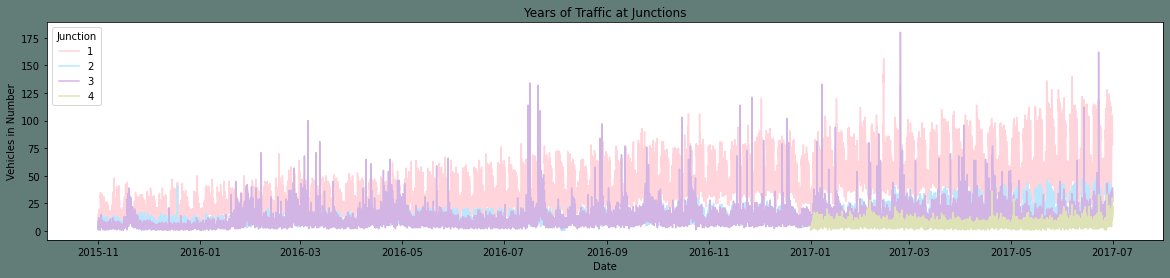

In [5]:
dataframe=dataset.copy()  
  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]  
plt.figure(figsize=(20,4),facecolor="#627D78")  
Time_series=sns.lineplot(x=dataframe['DateTime'],y="Vehicles",data=dataframe, hue="Junction", palette=colors)  
Time_series.set_title("Years of Traffic at Junctions")  
Time_series.set_ylabel("Vehicles in Number")  
Time_series.set_xlabel("Date")

In [6]:
#Feature Engineering
dataframe["Year"]= dataframe['DateTime'].dt.year  
dataframe["Month"]= dataframe['DateTime'].dt.month  
dataframe["Date_no"]= dataframe['DateTime'].dt.day  
dataframe["Hour"]= dataframe['DateTime'].dt.hour  
dataframe["Day"]= dataframe.DateTime.dt.strftime("%A")  
dataframe.head()  

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


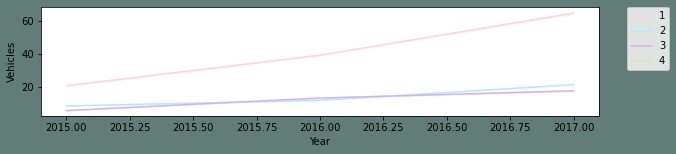

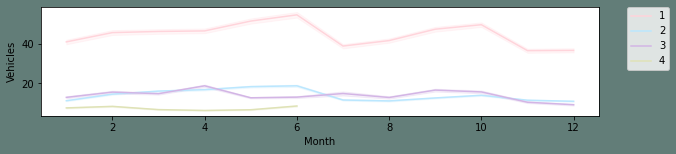

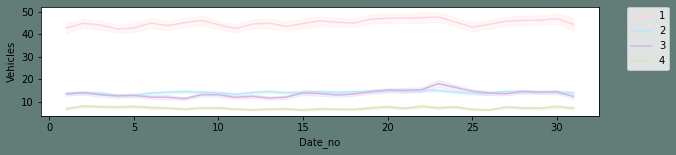

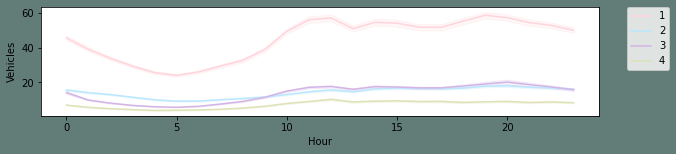

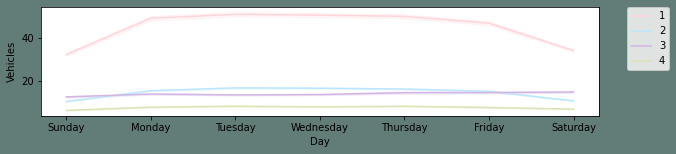

In [7]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]  
  
for i in new_features:  
    plt.figure(figsize=(10,2),facecolor="#627D78")  
    ax=sns.lineplot(x=dataframe[i],y="Vehicles",data=dataframe, hue="Junction", palette=colors )  
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  

Text(0.5, 0, 'Date')

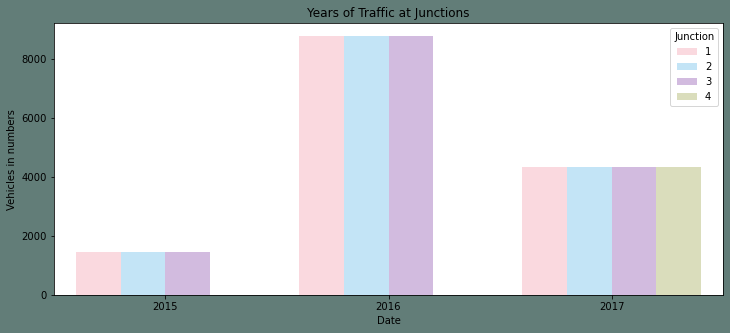

In [8]:
plt.figure(figsize=(12,5),facecolor="#627D78")  
count = sns.countplot(data=dataframe, x =dataframe["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date")  

In [9]:
#Data Transformation and Preprocessing
dataframe_junction = dataset.pivot(columns="Junction", index="DateTime")  
dataframe_junction.describe()  

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

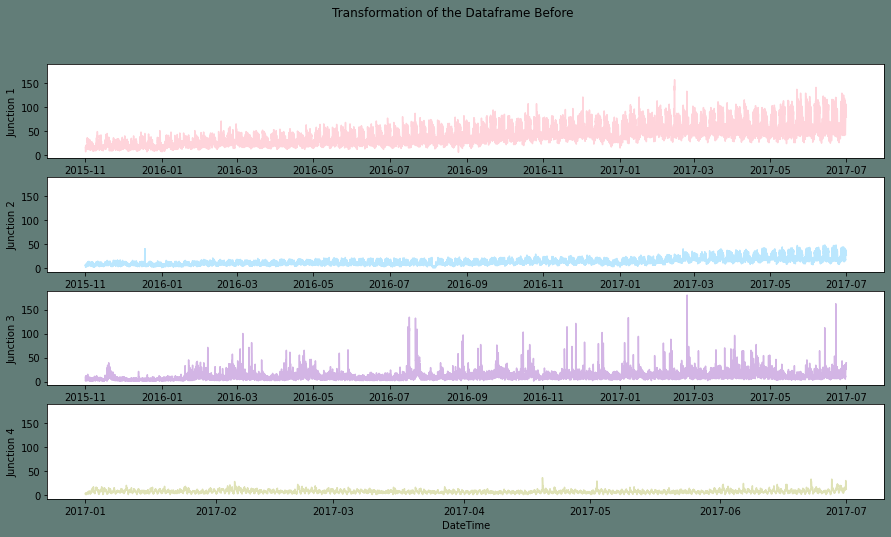

In [10]:
dataframe_1 = dataframe_junction[[('Vehicles', 1)]]  
dataframe_2 = dataframe_junction[[('Vehicles', 2)]]  
dataframe_3 = dataframe_junction[[('Vehicles', 3)]]  
dataframe_4 = dataframe_junction[[('Vehicles', 4)]]  
dataframe_4 = dataframe_4.dropna() #For only a few months, Junction 4 has only had minimal data.  
  
list_dfs = [dataframe_1, dataframe_2, dataframe_3, dataframe_4]  
for i in list_dfs:  
    i.columns= i.columns.droplevel(level=1)    
  
 
def Sub_Plots4(dataframe_1, dataframe_2,dataframe_3,dataframe_4,title):  
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)  
    fig.suptitle(title)  
    #J1  
    pl_1=sns.lineplot(ax=axes[0],data=dataframe_1,color=colors[0])  
    #pl_1=plt.ylabel()  
    axes[0].set(ylabel ="Junction 1")  
    #J2  
    pl_2=sns.lineplot(ax=axes[1],data=dataframe_2,color=colors[1])  
    axes[1].set(ylabel ="Junction 2")  
    #J3  
    pl_3=sns.lineplot(ax=axes[2],data=dataframe_3,color=colors[2])  
    axes[2].set(ylabel ="Junction 3")  
    #J4  
    pl_4=sns.lineplot(ax=axes[3],data=dataframe_4,color=colors[3])  
    axes[3].set(ylabel ="Junction 4")  
     
     
# It is displayed to test for stationarity.  
Sub_Plots4(dataframe_1.Vehicles, dataframe_2.Vehicles,dataframe_3.Vehicles,dataframe_4.Vehicles,"Transformation of the Dataframe Before")

In [11]:
# Normalize Function  
def Normalize(dataframe,column):  
    average = dataframe[column].mean()  
    stdev = dataframe[column].std()  
    df_normalized = (dataframe[column] - average) / stdev  
    df_normalized = df_normalized.to_frame()  
    return df_normalized, average, stdev  
  
# Differencing Function  
def Difference(dataframe,column, interval):  
    diff = []  
    for i in range(interval, len(dataframe)):  
        value = dataframe[column][i] - dataframe[column][i - interval]  
        diff.append(value)  
    return diff  

In [12]:
# In order to make the series stationary, normalize and differ  
dataframe_N1, avg_J1, std_J1 = Normalize(dataframe_1, "Vehicles")  
Diff_1 = Difference(dataframe_N1, column="Vehicles", interval=(24*7)) #taking a week's difference  
dataframe_N1 = dataframe_N1[24*7:]  
dataframe_N1.columns = ["Norm"]  
dataframe_N1["Diff"]= Diff_1  
  
dataframe_N2, avg_J2, std_J2 = Normalize(dataframe_2, "Vehicles")  
Diff_2 = Difference(dataframe_N2, column="Vehicles", interval=(24)) #taking a day's difference  
dataframe_N2 = dataframe_N2[24:]  
dataframe_N2.columns = ["Norm"]  
dataframe_N2["Diff"]= Diff_2  
  
dataframe_N3, avg_J3, std_J3 = Normalize(dataframe_3, "Vehicles")  
Diff_3 = Difference(dataframe_N3, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N3 = dataframe_N3[1:]  
dataframe_N3.columns = ["Norm"]  
dataframe_N3["Diff"]= Diff_3  
  
dataframe_N4, avg_J4, std_J4 = Normalize(dataframe_4, "Vehicles")  
Diff_4 = Difference(dataframe_N4, column="Vehicles", interval=1) #taking an hour's difference  
dataframe_N4 = dataframe_N4[1:]  
dataframe_N4.columns = ["Norm"]  
dataframe_N4["Diff"]= Diff_4  

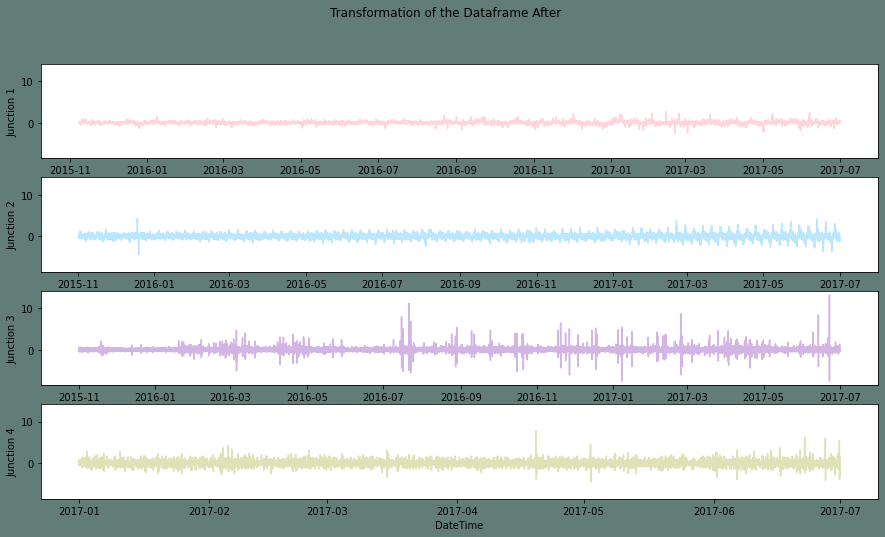

In [13]:
Sub_Plots4(dataframe_N1.Diff, dataframe_N2.Diff,dataframe_N3.Diff,dataframe_N4.Diff,"Transformation of the Dataframe After")

In [19]:
dataframe_J1 = dataframe_N1["Diff"].dropna()  
dataframe_J1 = dataframe_J1.to_frame()  
  
dataframe_J2 = dataframe_N2["Diff"].dropna()  
dataframe_J2 = dataframe_J2.to_frame()  
  
dataframe_J3 = dataframe_N3["Diff"].dropna()  
dataframe_J3 = dataframe_J3.to_frame()  
  
dataframe_J4 = dataframe_N4["Diff"].dropna()  
dataframe_J4 = dataframe_J4.to_frame()

def Split_data(dataframe):  
    training_size = int(len(dataframe)*0.90)  
    data_len = len(dataframe)  
    train, test = dataframe[0:training_size],dataframe[training_size:data_len]  
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)  
    return train, test  
  
Junction1_train, Junction1_test = Split_data(dataframe_J1)  
Junction2_train, Junction2_test = Split_data(dataframe_J2)  
Junction3_train, Junction3_test = Split_data(dataframe_J3)  
Junction4_train, Junction4_test = Split_data(dataframe_J4)   

In [20]:
def target_and_feature(dataframe):  
    end_len = len(dataframe)  
    X = []  
    y = []  
    steps = 32  
    for i in range(steps, end_len):  
        X.append(dataframe[i - steps:i, 0])  
        y.append(dataframe[i, 0])  
    X, y = np.array(X), np.array(y)  
    return X ,y  
  
# fixing the shape of X_test and X_train  
def FeatureFixShape(train, test):  
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))  
    test = np.reshape(test, (test.shape[0],test.shape[1],1))  
    return train, test

In [21]:
X_train_Junction1, y_train_Junction1 = target_and_feature(Junction1_train)  
X_test_Junction1, y_test_Junction1 = target_and_feature(Junction1_test)  
X_train_Junction1, X_test_Junction1 = FeatureFixShape(X_train_Junction1, X_test_Junction1)  
  
X_train_Junction2, y_train_Junction2 = target_and_feature(Junction2_train)  
X_test_Junction2, y_test_Junction2 = target_and_feature(Junction2_test)  
X_train_Junction2, X_test_Junction2 = FeatureFixShape(X_train_Junction2, X_test_Junction2)  
  
X_train_Junction3, y_train_Junction3 = target_and_feature(Junction3_train)  
X_test_Junction3, y_test_Junction3 = target_and_feature(Junction3_test)  
X_train_Junction3, X_test_Junction3 = FeatureFixShape(X_train_Junction3, X_test_Junction3)  
  
X_train_Junction4, y_train_Junction4 = target_and_feature(Junction4_train)  
x_test_Junction4, y_test_Junction4 = target_and_feature(Junction4_test)  
X_train_Junction4, x_test_Junction4 = FeatureFixShape(X_train_Junction4, x_test_Junction4)  

In [28]:
#Model Building
def GRU_model(X_Train, y_Train, X_Test):  
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)  
     
      
    model = Sequential()  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
     
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))  
    model.add(Dropout(0.2))  
    model.add(Dense(units=1))  
     
    # Compiling the model  
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=tf.keras.losses.MeanSquaredError())  
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])  
    pred_GRU= model.predict(X_Test)  
    return pred_GRU  
  
def RMSE_Value(test,predicted):  
    rmse = math.sqrt(mean_squared_error(test, predicted))  
    print("The root mean squared error is {}.".format(rmse))  
    return rmse  
  
def PredictionsPlot(test,predicted,m):  
    plt.figure(figsize=(12,5),facecolor="#627D78")  
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )  
    plt.plot(predicted, color="#627D78",label="Predicted Values")  
    plt.title("GRU Traffic Prediction Vs True values")  
    plt.xlabel("DateTime")  
    plt.ylabel("Number of Vehicles")  
    plt.legend()  
    plt.show()  

In [29]:
#Fitting the model
PredJ1 = GRU_model(X_train_Junction1,y_train_Junction1,X_test_Junction1) 

Epoch 1/50
87/87 [==============================] - 25s 212ms/step - loss: 0.0660
Epoch 2/50
87/87 [==============================] - 19s 221ms/step - loss: 0.0484
Epoch 3/50
87/87 [==============================] - 20s 225ms/step - loss: 0.0479
Epoch 4/50
87/87 [==============================] - 20s 229ms/step - loss: 0.0484
Epoch 5/50
87/87 [==============================] - 21s 238ms/step - loss: 0.0474
Epoch 6/50
87/87 [==============================] - 23s 268ms/step - loss: 0.0471
Epoch 7/50
87/87 [==============================] - 21s 246ms/step - loss: 0.0487
Epoch 8/50
87/87 [==============================] - 25s 285ms/step - loss: 0.0469
Epoch 9/50
87/87 [==============================] - 21s 244ms/step - loss: 0.0467
Epoch 10/50
87/87 [==============================] - 21s 243ms/step - loss: 0.0472
Epoch 11/50
87/87 [==============================] - 23s 266ms/step - loss: 0.0462
Epoch 12/50
87/87 [==============================] - 24s 278ms/step - loss: 0.0469
Epoch 13/50
8

Epoch 32/50
87/87 [==============================] - 22s 257ms/step - loss: 0.0556
Epoch 33/50
87/87 [==============================] - 23s 265ms/step - loss: 0.0554
Epoch 34/50
87/87 [==============================] - 23s 262ms/step - loss: 0.0540
Epoch 35/50
87/87 [==============================] - 22s 259ms/step - loss: 0.0566
Epoch 36/50
87/87 [==============================] - 22s 249ms/step - loss: 0.0544
Epoch 37/50
87/87 [==============================] - 23s 260ms/step - loss: 0.0549
Epoch 38/50
87/87 [==============================] - 22s 256ms/step - loss: 0.0531
Epoch 39/50
87/87 [==============================] - 23s 267ms/step - loss: 0.0534
Epoch 40/50
87/87 [==============================] - 25s 287ms/step - loss: 0.0544
Epoch 41/50
87/87 [==============================] - 23s 264ms/step - loss: 0.0529
Epoch 42/50
87/87 [==============================] - 30s 351ms/step - loss: 0.0517
Epoch 43/50
87/87 [==============================] - 30s 341ms/step - loss: 0.0524
Epoc

The root mean squared error is 0.2537800865796726.


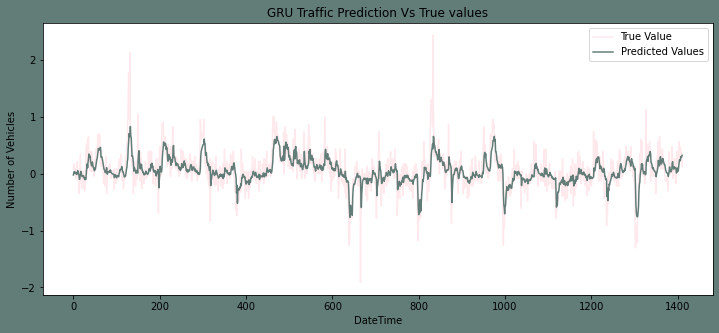

In [30]:
#Results for J1  
RMSE_J1=RMSE_Value(y_test_Junction1,PredJ1)  
PredictionsPlot(y_test_Junction1,PredJ1,0)  

In [34]:
PredJ2 = GRU_model(X_train_Junction2,y_train_Junction2,X_test_Junction2)

Epoch 1/50
88/88 [==============================] - 35s 309ms/step - loss: 0.2382
Epoch 2/50
88/88 [==============================] - 26s 290ms/step - loss: 0.1865
Epoch 3/50
88/88 [==============================] - 23s 265ms/step - loss: 0.1840
Epoch 4/50
88/88 [==============================] - 23s 258ms/step - loss: 0.1838
Epoch 5/50
88/88 [==============================] - 24s 272ms/step - loss: 0.1800
Epoch 6/50
88/88 [==============================] - 24s 276ms/step - loss: 0.1819
Epoch 7/50
88/88 [==============================] - 25s 283ms/step - loss: 0.1822
Epoch 8/50
88/88 [==============================] - 25s 280ms/step - loss: 0.1783
Epoch 9/50
88/88 [==============================] - 23s 263ms/step - loss: 0.1760
Epoch 10/50
88/88 [==============================] - 26s 289ms/step - loss: 0.1786
Epoch 11/50
88/88 [==============================] - 23s 256ms/step - loss: 0.1763
Epoch 12/50
88/88 [==============================] - 24s 271ms/step - loss: 0.1767
Epoch 13/50
8

Epoch 32/50
88/88 [==============================] - 24s 273ms/step - loss: 0.1818
Epoch 33/50
88/88 [==============================] - 24s 270ms/step - loss: 0.1877
Epoch 34/50
88/88 [==============================] - 24s 274ms/step - loss: 0.1876
Epoch 35/50
88/88 [==============================] - 23s 263ms/step - loss: 0.1820
Epoch 36/50
88/88 [==============================] - 24s 272ms/step - loss: 0.1916
Epoch 37/50
88/88 [==============================] - 24s 271ms/step - loss: 0.1902
Epoch 38/50
88/88 [==============================] - 24s 271ms/step - loss: 0.1871
Epoch 39/50
88/88 [==============================] - 23s 266ms/step - loss: 0.1898
Epoch 40/50
88/88 [==============================] - 24s 275ms/step - loss: 0.1844
Epoch 41/50
88/88 [==============================] - 25s 287ms/step - loss: 0.1855
Epoch 42/50
88/88 [==============================] - 24s 275ms/step - loss: 0.1874
Epoch 43/50
88/88 [==============================] - 24s 277ms/step - loss: 0.1878
Epoc

The root mean squared error is 0.5405828063903988.


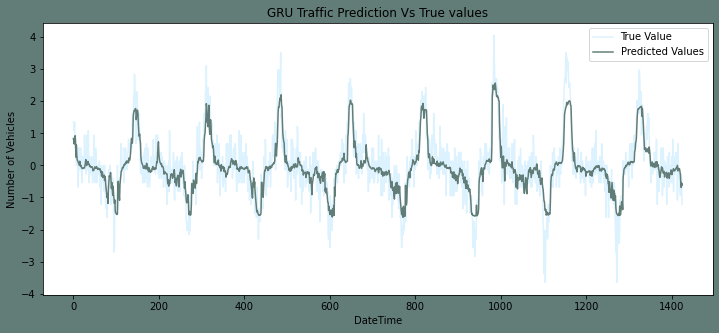

In [35]:
RMSE_J2=RMSE_Value(y_test_Junction2,PredJ2)  
PredictionsPlot(y_test_Junction2,PredJ2,1)

In [36]:
PredJ3 = GRU_model(X_train_Junction3,y_train_Junction3,X_test_Junction3) 

Epoch 1/50
88/88 [==============================] - 56s 450ms/step - loss: 0.3096
Epoch 2/50
88/88 [==============================] - 40s 451ms/step - loss: 0.2778
Epoch 3/50
88/88 [==============================] - 40s 450ms/step - loss: 0.2697
Epoch 4/50
88/88 [==============================] - 40s 453ms/step - loss: 0.2692
Epoch 5/50
88/88 [==============================] - 40s 451ms/step - loss: 0.2706
Epoch 6/50
88/88 [==============================] - 40s 454ms/step - loss: 0.2750
Epoch 7/50
88/88 [==============================] - 40s 451ms/step - loss: 0.2613
Epoch 8/50
88/88 [==============================] - 40s 455ms/step - loss: 0.2902
Epoch 9/50
88/88 [==============================] - 40s 455ms/step - loss: 0.2765
Epoch 10/50
88/88 [==============================] - 39s 448ms/step - loss: 0.2707
Epoch 11/50
88/88 [==============================] - 39s 447ms/step - loss: 0.2629
Epoch 12/50
88/88 [==============================] - 39s 447ms/step - loss: 0.2815
Epoch 13/50
8

Epoch 32/50
88/88 [==============================] - 40s 449ms/step - loss: 0.3034
Epoch 33/50
88/88 [==============================] - 40s 450ms/step - loss: 0.3033
Epoch 34/50
88/88 [==============================] - 39s 449ms/step - loss: 0.3029
Epoch 35/50
88/88 [==============================] - 42s 474ms/step - loss: 0.3037
Epoch 36/50
88/88 [==============================] - 41s 469ms/step - loss: 0.3036
Epoch 37/50
88/88 [==============================] - 41s 463ms/step - loss: 0.3029
Epoch 38/50
88/88 [==============================] - 40s 454ms/step - loss: 0.3035
Epoch 39/50
88/88 [==============================] - 40s 455ms/step - loss: 0.3028
Epoch 40/50
88/88 [==============================] - 45s 509ms/step - loss: 0.3025
Epoch 41/50
88/88 [==============================] - 42s 480ms/step - loss: 0.3030
Epoch 42/50
88/88 [==============================] - 42s 480ms/step - loss: 0.3023
Epoch 43/50
88/88 [==============================] - 42s 481ms/step - loss: 0.3024
Epoc

The root mean squared error is 0.6343177510807644.


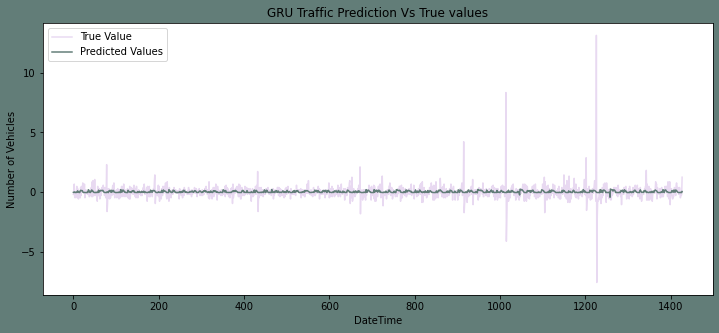

In [37]:
RMSE_J3=RMSE_Value(y_test_Junction3,PredJ3)  
PredictionsPlot(y_test_Junction3,PredJ3,2) 

In [38]:
PredJ4 = GRU_model(X_train_Junction4,y_train_Junction4,x_test_Junction4)

Epoch 1/50
26/26 [==============================] - 40s 932ms/step - loss: 0.7030
Epoch 2/50
26/26 [==============================] - 24s 934ms/step - loss: 0.6193
Epoch 3/50
26/26 [==============================] - 24s 933ms/step - loss: 0.6285
Epoch 4/50
26/26 [==============================] - 24s 928ms/step - loss: 0.6024
Epoch 5/50
26/26 [==============================] - 24s 933ms/step - loss: 0.5922
Epoch 6/50
26/26 [==============================] - 24s 931ms/step - loss: 0.5464
Epoch 7/50
26/26 [==============================] - 24s 929ms/step - loss: 0.5680
Epoch 8/50
26/26 [==============================] - 24s 929ms/step - loss: 0.5424
Epoch 9/50
26/26 [==============================] - 24s 927ms/step - loss: 0.5333
Epoch 10/50
26/26 [==============================] - 24s 934ms/step - loss: 0.5132
Epoch 11/50
26/26 [==============================] - 24s 933ms/step - loss: 0.5138
Epoch 12/50
26/26 [==============================] - 25s 945ms/step - loss: 0.4915
Epoch 13/50
2

Epoch 32/50
26/26 [==============================] - 24s 937ms/step - loss: 0.4772
Epoch 33/50
26/26 [==============================] - 24s 938ms/step - loss: 0.4656
Epoch 34/50
26/26 [==============================] - 24s 932ms/step - loss: 0.4585
Epoch 35/50
26/26 [==============================] - 24s 940ms/step - loss: 0.4674
Epoch 36/50
26/26 [==============================] - 24s 933ms/step - loss: 0.4816
Epoch 37/50
26/26 [==============================] - 24s 936ms/step - loss: 0.4668
Epoch 38/50
26/26 [==============================] - 24s 934ms/step - loss: 0.4831
Epoch 39/50
26/26 [==============================] - 24s 932ms/step - loss: 0.4957
Epoch 40/50
26/26 [==============================] - 24s 932ms/step - loss: 0.4970
Epoch 41/50
26/26 [==============================] - 24s 935ms/step - loss: 0.5059
Epoch 42/50
26/26 [==============================] - 24s 930ms/step - loss: 0.5309
Epoch 43/50
26/26 [==============================] - 24s 933ms/step - loss: 0.5170
Epoc

The root mean squared error is 1.0256722186617893.


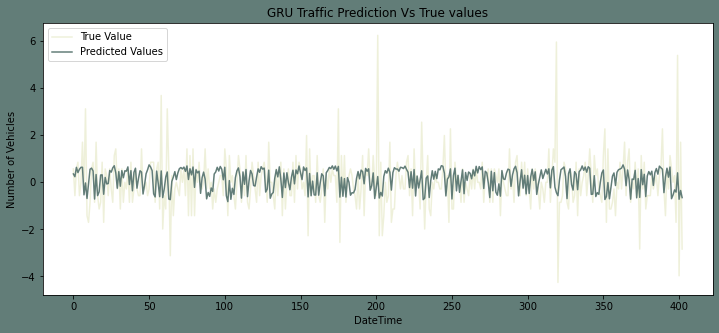

In [39]:
RMSE_J4=RMSE_Value(y_test_Junction4,PredJ4)  
PredictionsPlot(y_test_Junction4,PredJ4,3)  

In [40]:
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]  
RMSE = [RMSE_J1, RMSE_J2, RMSE_J3, RMSE_J4]  
list_of_tuples = list(zip(Junctions, RMSE))  
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE"])  
Results.style.background_gradient(cmap="Pastel1")    

,Junction,RMSE
0,Junction1,0.253780
1,Junction2,0.540583
2,Junction3,0.634318
3,Junction4,1.025672
